In [2]:

import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import importlib
import gru_functions 

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

print(device)

cpu


In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Define the relative path to the desired directory
relative_path = "data"

# Combine the current directory with the relative path to get the absolute path
absolute_path = os.path.join(current_dir, relative_path)
os.chdir(absolute_path)

In [4]:
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']


In [6]:
i = 10
df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift_df = shift_dataframe(df,i,columns_to_shift)
#shuffle_trials(shift_df)
#trials = TrialDataset(df,labels)


In [7]:
class TrialDataset(Dataset):
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.trials = df['trial'].unique()
        
        # Define features: All columns except 'trial' and the labels
        self.features = [col for col in df.columns if col not in labels + ['trial']]
        
        # Prepare the trial data in a list
        self.trial_data = [df[df['trial'] == trial][self.features].values for trial in self.trials]
        self.trial_labels = [df[df['trial'] == trial][self.labels].values for trial in self.trials]

    def __len__(self):
        return len(self.trials)
    
    def __getitem__(self, idx):
        # Return the raw sequence and corresponding labels
        X = self.trial_data[idx]
        y = torch.tensor(self.trial_labels[idx], dtype=torch.float32)
        
        return X, y

In [8]:
def collate_fn(batch):
    # Unzip the batch
    sequences, labels = zip(*batch)
    
    # Calculate lengths
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    # Determine the max length in the batch
    max_length = lengths.max().item()
    
    # Pad the sequences
    padded_sequences = torch.zeros(len(sequences), max_length, sequences[0].shape[1])  # Shape: (batch_size, max_length, feature_size)
    
    for i, seq in enumerate(sequences):
        seq_length = len(seq)
        padded_sequences[i, :seq_length] = torch.tensor(seq, dtype=torch.float32)  # Fill with original data
        
    return padded_sequences, torch.stack(labels), lengths

In [ ]:
def collate_fn(batch):
    # Unzip the batch
    sequences, labels = zip(*batch)
    
    # Calculate lengths
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    # Determine the max length in the batch
    max_length = lengths.max().item()
    
    # Initialize padded sequences tensor
    padded_sequences = torch.zeros(len(sequences), max_length, sequences[0].shape[1])  # Shape: (batch_size, max_length, feature_size)
    
    # Pad the sequences
    for i, seq in enumerate(sequences):
        seq_length = len(seq)
        padded_sequences[i, :seq_length] = torch.tensor(seq, dtype=torch.float32)  # Fill with original data
        
    return padded_sequences, torch.stack(labels), lengths

In [23]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])                                                                  
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)]) 
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        h = [torch.zeros(x.size(0), self.hidden_dim, device=x.device) for _ in range(self.num_layers)]  # Initialize hidden states
        
        # Process through the GRU layers
        for t in range(packed_input.data.size(0)):  # Iterate through time steps
            input_t = packed_input.data[t]
            for layer_idx, (gru_cell, layer_norm) in enumerate(zip(self.gru_cells, self.layer_norms)):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])  # Compute new hidden state
                h[layer_idx] = layer_norm(h[layer_idx])  # Apply layer normalization
                input_t = h[layer_idx]  # Normalize hidden state becomes input for next step 

        out = self.fc(h[-1])  # Output using the last layer's hidden state

        return out, h

In [10]:
# Create the dataset and dataloader
trials_dataset = TrialDataset(shift_df, labels)
dataloader = DataLoader(trials_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)

# Example of how to use the dataloader in a training loop
model = GRUCellNet(input_dim=16, hidden_dim=1, output_dim=11, num_layers=1)

#for padded_sequences, labels, lengths in dataloader:
 #   output, hidden_states = model(padded_sequences, lengths)

In [17]:
for padded_sequences, labels, lengths in dataloader:
   print(padded_sequences.shape)

torch.Size([1, 689, 16])
torch.Size([1, 440, 16])
torch.Size([1, 737, 16])
torch.Size([1, 528, 16])
torch.Size([1, 488, 16])
torch.Size([1, 775, 16])
torch.Size([1, 591, 16])
torch.Size([1, 603, 16])
torch.Size([1, 350, 16])
torch.Size([1, 636, 16])
torch.Size([1, 518, 16])
torch.Size([1, 151, 16])
torch.Size([1, 335, 16])
torch.Size([1, 404, 16])
torch.Size([1, 482, 16])


In [12]:
print(shift_df.isnull().sum())

trial            0
aAngHG_oHead     0
aAngHG_oMid      0
aAngHG_oReach    0
aAngHGFeed1      0
aAngHGFeed2      0
aAngHGFeed3      0
aAngHGFeed4      0
aDistReach_1     0
aDistReach_2     0
aDistReach_3     0
aDistReach_4     0
oAngHGFeed1      0
oAngHGFeed2      0
oAngHGFeed3      0
oAngHGFeed4      0
oDistReach1      0
oDistReach2      0
oDistReach3      0
oDistReach4      0
s_1              0
s_2              0
s_3              0
s_4              0
b_1              0
b_2              0
b_3              0
b_4              0
dtype: int64


# second try

In [18]:
class TrialDataset(Dataset):
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.trials = df['trial'].unique()
        self.features = [col for col in df.columns if col not in labels + ['trial']]
    
    def __len__(self):
        return len(self.trials)
    
    def __getitem__(self, idx):
        trial = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial]
        
        # Convert features to a tensor
        X = torch.tensor(trial_data[self.features].values, dtype=torch.float32)
        # Convert labels to a tensor
        y = torch.tensor(trial_data[self.labels].values, dtype=torch.float32)
        
        length = X.size(0)  # The number of time steps for this trial
        return X, y, length

In [21]:
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift_df = shift_dataframe(df,i,columns_to_shift)

# Create the dataset
trials_dataset = TrialDataset(shift_df, labels)

# Set batch size to 1
dataloader = DataLoader(trials_dataset, batch_size=1, shuffle=False)  # No need for collate_fn if you're not batching multiple sequences


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrialDataset(Dataset):
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.trials = df['trial'].unique()
        
        # Define features: All columns except 'trial' and the labels
        self.features = [col for col in df.columns if col not in labels + ['trial']]
        
    def __len__(self):
        return len(self.trials)
    
    def __getitem__(self, idx):
        trial = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial]
        
        # Convert features and labels to tensors
        X = torch.tensor(trial_data[self.features].values, dtype=torch.float32)
        y = torch.tensor(trial_data[self.labels].values, dtype=torch.float32)
        
        length = X.size(0)  # The number of time steps for this trial
        return X, y, length

def collate_fn(batch):
    # Unzip the batch
    sequences, labels, lengths = zip(*batch)

    # Calculate lengths
    lengths = torch.tensor(lengths)

    # Determine the max length in the batch
    #max_length = lengths.max().item()
    
    # Pad the sequences
    padded_sequences = torch.zeros(len(sequences), max_length, sequences[0].shape[1])  # Shape: (batch_size, max_length, feature_size)

    for i, seq in enumerate(sequences):
        seq_length = len(seq)
        padded_sequences[i, :seq_length] = seq  # Fill with original data
        
    return padded_sequences, torch.stack(labels), lengths


import torch
import torch.nn as nn

class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUCellNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Create a list of GRUCells
        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim if i == 0 else hidden_dim, hidden_dim) 
            for i in range(num_layers)
        ])

        # Layer Normalization for each layer
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        batch_size = x.size(0)

        # Initialize hidden states for all layers
        h = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        # Process each time step in the sequence
        for t in range(x.size(1)):
            input_t = x[:, t, :]  # Get the input at time step t

            # Update the hidden state for each layer
            for layer_idx in range(self.num_layers):
                h[layer_idx] = self.gru_cells[layer_idx](input_t, h[layer_idx])
                h[layer_idx] = self.layer_norms[layer_idx](h[layer_idx])  # Layer normalization
                input_t = h[layer_idx]  # The output becomes the next input

        # Use the last hidden state of the last layer for output
        out = self.fc(h[-1])
        
        return out



In [27]:
# Create the dataset and dataloader
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift_df = shift_dataframe(df,i,columns_to_shift)
trials_dataset = TrialDataset(df, labels)
dataloader = DataLoader(trials_dataset, batch_size=1, collate_fn=collate_fn, shuffle=Fa)

# Example of how to use the dataloader in a training loop
model = GRUCellNet(input_dim=16, hidden_dim=32, output_dim=11, num_layers=1)

for padded_sequences, labels, lengths in dataloader:
    output = model(padded_sequences, lengths)
    print(padded_sequences)  # Check the output shape

tensor([[[38.3094, 16.6272, 24.5210,  ...,  0.0000,  0.0000,  0.0000],
         [38.3191, 16.6471, 24.5591,  ...,  0.0000,  0.0000,  0.0000],
         [38.3357, 16.6548, 24.5744,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [54.9193, 25.3974,  6.3239,  ...,  0.0000,  0.0000,  0.0000],
         [54.0766, 24.6619,  7.4166,  ...,  0.0000,  0.0000,  0.0000],
         [52.7457, 23.5907,  8.0810,  ...,  0.0000,  0.0000,  0.0000]]])
tensor([[[39.3540, 17.4018, 23.9943,  ...,  0.0000,  0.0000,  0.0000],
         [39.3153, 17.3057, 23.7565,  ...,  0.0000,  0.0000,  0.0000],
         [39.0424, 17.2000, 24.1148,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [43.1931, 18.4353, 22.6533,  ...,  0.0000,  0.0000,  1.0000],
         [43.1779, 18.5144, 22.7983,  ...,  0.0000,  0.0000,  1.0000],
         [43.0838, 18.5862, 23.0506,  ...,  0.0000,  0.0000,  1.0000]]])
tensor([[[39.5840, 17.2408, 24.1876,  ...,  0.0000,  0.0000,  0.0000],
         [39.5829, 17.2337, 24.2065,  ...,  0

In [46]:
class TrialDataset(Dataset):
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.trials = df['trial'].unique()
        
        # Define features: All columns except 'trial' and the labels
        self.features = [col for col in df.columns if col not in labels + ['trial']]
        
    def __len__(self):
        return len(self.trials)
    
    def __getitem__(self, idx):
        trial = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial]
        
        # Convert features and labels to tensors
        X = torch.tensor(trial_data[self.features].values, dtype=torch.float32)
        y = torch.tensor(trial_data[self.labels].values, dtype=torch.float32)
        
        
        return X, y
    
    
def collate_fn(batch):
    sequences, labels = zip(*batch)
    
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    padded_sequences = pad_sequence(sequences, batch_first = True)
    
    for i, seq in enumerate(sequences):
        seq_length = len(seq)
        padded_sequences[i, :seq_length] = seq.clone().detach()  # Use clone and detach

    return padded_sequences, torch.stack(labels), lengths




class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GRUCellNet, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.gru_cells = nn.ModuleList([nn.GRUCell(input_dim, hidden_dim) for _ in range(num_layers)])
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, padded_sequences, lengths):
        packed_input = pack_padded_sequence(padded_sequences, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Initialize hidden state
        h = [torch.zeros(padded_sequences.size(0), self.hidden_dim).to(padded_sequences.device) for _ in range(self.num_layers)]
        
        for t in range(packed_input.data.size(1)):  # Iterate over time steps
            input_t = packed_input.data[:, t, :].unsqueeze(0)  # Get the input at time step t
            
            for layer_idx in range(self.num_layers):
                h[layer_idx] = self.gru_cells[layer_idx](input_t, h[layer_idx])
                input_t = h[layer_idx]  # The output becomes the next input
        
        # Optionally, return the final output of the last time step
        output = self.fc(h[-1])
        return output





In [48]:
# Create the dataset and dataloader
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift_df = shift_dataframe(df,i,columns_to_shift)
trials_dataset = TrialDataset(df, labels)
dataloader = DataLoader(trials_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)

# Example of how to use the dataloader in a training loop
model = GRUCellNet(input_dim=16, hidden_dim=32, output_dim=11, num_layers=1)

for padded_sequences, labels, lengths in dataloader:
    output = model(padded_sequences, lengths)
    print(padded_sequences[1])  # Check the output shape

ValueError: too many values to unpack (expected 2)

# 15 trials -> sequences as 1 batch

In [4]:
def create_dataloaders(df, val_set_trial, test_set_trial=None, features_columns=None, label_columns=None, batch_size=None):
    """
    Splits the data into training, validation, and optionally test sets and creates DataLoaders for each.

    Args:
        df (pd.DataFrame): The entire dataframe containing trials, features, and labels.
        val_set_trial (int): The trial number to use for validation.
        test_set_trial (int, optional): The trial number to use for testing. If None, no test set will be created.
        features_columns (list): The list of feature column names.
        label_columns (list): The list of label column names.
        batch_size (int, optional): The batch size for training, validation, and test sets.
            If not provided, batch size is equal to the number of unique trials in each set.

    Returns:
        train_dataloader, val_dataloader, test_dataloader (optional): DataLoader objects for training, validation, and testing.
    """
    # Filter the dataframe to get training, validation, and optionally test sets
    train_set = df[(df['trial'] != val_set_trial) & (df['trial'] != test_set_trial if test_set_trial is not None else True)]
    val_set = df[df['trial'] == val_set_trial]
    
    # Create dataset objects
    train_dataset = TrialDataset(train_set, features_columns, label_columns)
    val_dataset = TrialDataset(val_set, features_columns, label_columns)

    # Determine batch size based on unique trials if not provided
    train_batch_size = batch_size if batch_size else len(train_set['trial'].unique())
    val_batch_size = batch_size if batch_size else len(val_set['trial'].unique())

    # Create DataLoader objects for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, collate_fn=collate_fn, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, collate_fn=collate_fn, shuffle=True)

    # Check if test_set_trial is provided to create test DataLoader
    if test_set_trial is not None:
        test_set = df[df['trial'] == test_set_trial]
        test_dataset = TrialDataset(test_set, features_columns, label_columns)
        test_batch_size = batch_size if batch_size else len(test_set['trial'].unique())
        test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=collate_fn, shuffle=True)
        return train_dataloader, val_dataloader, test_dataloader
    
    return train_dataloader, val_dataloader

In [63]:
class TrialDataset(Dataset):
    def __init__(self, df, features_columns, label_columns):
        self.df = df
        self.features_columns = features_columns
        self.label_columns = label_columns
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Get the features for the trial
        features = trial_data[self.features_columns].values  # Shape: [sequence_length, num_features]
        
        # Get the labels (you can modify this depending on how you want to handle labels)
        labels = trial_data[self.label_columns].iloc[0].values  # Assuming the same label for the entire trial
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)



In [80]:
# Create the dataset and dataloader
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift_df = shift_dataframe(df,i,columns_to_shift)
# Create the dataset
dataset = TrialDataset(shift_df, columns_to_shift, labels)

In [101]:
# Create a dataloader with batch size = number of trials
# Create the dataset and dataloader
test_set = 1
val_set = 2
i = 10
df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,i,columns_to_shift)
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,i,columns_to_shift)
train_set = shifted_df[(shifted_df['trial'] != test_set)&(shifted_df['trial'] != val_set)]
val_set = shifted_df[shifted_df['trial'] == val_set]
test_set = shifted_df[shifted_df['trial'] == test_set]

train_dataset = TrialDataset(train_set, columns_to_shift, labels)
val_dataset = TrialDataset(val_set, columns_to_shift, labels)
test_dataset = TrialDataset(test_set, columns_to_shift, labels)


train_dataloader = DataLoader(train_dataset, batch_size=len(train_set['trial'].unique()), collate_fn=collate_fn, shuffle=True)  # Shuffling trials per epoch
test_dataloader = DataLoader(test_dataset, batch_size=len(test_set['trial'].unique()),collate_fn=collate_fn,shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_set['trial'].unique()),collate_fn=collate_fn, shuffle=True)


In [105]:
len(train_set['trial'].unique())

13

In [92]:
class GRUCellNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUCellNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRUCell layers
        self.gru_cells = torch.nn.ModuleList([torch.nn.GRUCell(input_dim if i == 0 else hidden_dim, hidden_dim) 
                                              for i in range(num_layers)])
        
        # Fully connected layer for output
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.size()

        # Initialize hidden states for each layer
        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        
        # Loop through each timestep
        outputs = []
        for t in range(seq_len):
            input_t = x[:, t, :]  # Get inputs for the current timestep
            
            # Pass through each GRU cell layer
            for i, gru_cell in enumerate(self.gru_cells):
                h[i] = gru_cell(input_t, h[i])  # Update hidden state
                input_t = h[i]  # Output of the previous layer becomes the input to the next layer
            
            outputs.append(h[-1])  # Collect the output from the last layer
        
        # Stack outputs and retrieve final valid output based on the sequence lengths
        outputs = torch.stack(outputs, dim=1)  # Stack along the time dimension
        final_outputs = torch.stack([outputs[i, length-1, :] for i, length in enumerate(lengths)])
        
        # Pass through the fully connected layer
        return self.fc(final_outputs)


In [93]:
# Instantiate the model
model = GRUCellNet(input_dim=16, hidden_dim=32, output_dim=11, num_layers=1)

# Example training loop
for padded_sequences, padded_labels, lengths in dataloader:
    output = model(padded_sequences, lengths)
    print(f"Output: {output.shape}")
    print(output[5])

Output: torch.Size([15, 11])
tensor([ 0.6154, -0.0240, -0.4673, -0.7620,  0.1594,  0.5193,  0.8761, -0.8107,
         0.3670,  0.2035,  0.9257], grad_fn=<SelectBackward0>)


In [1]:
# Example model definition
class GRUCellNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUCellNet, self).__init__()
        self.gru = torch.nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        # Pack the padded sequences
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through the GRU
        packed_output, _ = self.gru(packed_input)
        
        # Unpack the sequences
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Extract the last valid output for each sequence (based on original lengths)
        final_outputs = torch.stack([output[i, length-1, :] for i, length in enumerate(lengths)])
        
        # Pass through the fully connected layer
        return self.fc(final_outputs)

# Instantiate the model
model = GRUCellNet(input_dim=16, hidden_dim=32, output_dim=11, num_layers=1)

# Example training loop
for padded_sequences, padded_labels, lengths in dataloader:
    output = model(padded_sequences, lengths)
    print(f"Output: {output.shape}")
    print(output[5])

NameError: name 'torch' is not defined

In [98]:
test_set = 1
val_set = 2
# Create the dataset and dataloader
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,i,columns_to_shift)
# Split the data into training and test sets based on 'trial' column
train_set = shifted_df[(shifted_df['trial'] != test_set)&(shifted_df['trial'] != val_set)].drop(columns=['trial'])
val_set = shifted_df[shifted_df['trial'] == val_set].drop(columns=['trial'])
test_set = shifted_df[shifted_df['trial'] == test_set].drop(columns=['trial'])
full_set = shifted_df.drop(columns=['trial'])

# Split data into X (features) and y (labels)
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_val, y_val = val_set.drop(columns=labels), val_set[labels]
X_test, y_test = test_set.drop(columns=labels), test_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]
# Reset index for consistency
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X, y = X.reset_index(drop=True), y.reset_index(drop=True)

In [116]:
# Hyperparameters
test_set = 1
val_set = 2
# Create the dataset and dataloader
i = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)


input_dim = len(columns_to_shift)  # Number of features
hidden_dim = 32
output_dim = len(labels)  # Number of labels
num_layers = 1
learning_rate = 0.001
num_epochs = 10


train_dataloader, val_dataloader = create_dataloaders(shifted_df,val_set_trial=val_set,features_columns=columns_to_shift,label_columns=labels)

# Initialize the model, loss function, and optimizer
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()  # Assuming you're working with regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for padded_sequences, labels, lengths in train_dataloader:
        # Move data to GPU if available
        padded_sequences, labels, lengths = padded_sequences.to(model.fc.weight.device), labels.to(model.fc.weight.device), lengths.to(model.fc.weight.device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(padded_sequences, lengths)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    
    # Validation phase after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for padded_sequences, labels, lengths in val_dataloader:
            padded_sequences, labels, lengths = padded_sequences.to(model.fc.weight.device), labels.to(model.fc.weight.device), lengths.to(model.fc.weight.device)
            
            # Forward pass
            outputs = model(padded_sequences, lengths)
            
            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}],Training Loss: {running_loss/len(train_dataloader):.4f}, Validation Loss: {val_loss/len(val_dataloader):.4f}")

Epoch [1/10],Training Loss: 1057.3993, Validation Loss: 751.5514
Epoch [2/10],Training Loss: 1055.4386, Validation Loss: 749.8674
Epoch [3/10],Training Loss: 1053.5082, Validation Loss: 748.1869
Epoch [4/10],Training Loss: 1051.6094, Validation Loss: 746.5110
Epoch [5/10],Training Loss: 1049.7407, Validation Loss: 744.8391
Epoch [6/10],Training Loss: 1047.8983, Validation Loss: 743.1696
Epoch [7/10],Training Loss: 1046.0768, Validation Loss: 741.5035
Epoch [8/10],Training Loss: 1044.2721, Validation Loss: 739.8439
Epoch [9/10],Training Loss: 1042.4817, Validation Loss: 738.1953
Epoch [10/10],Training Loss: 1040.7047, Validation Loss: 736.5621


In [115]:
# Hyperparameters
test_set = 1
val_set = 2
# Create the dataset and dataloader
shift = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)


#train_dataloader, val_dataloader = create_dataloaders(shifted_df,val_set_trial=val_set,features_columns=columns_to_shift,label_columns=labels)

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4'],
      dtype='object')
y_batch shape: torch.Size([14, 11]), y_pred shape: torch.Size([14, 11])


c:\Users\kacpe\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


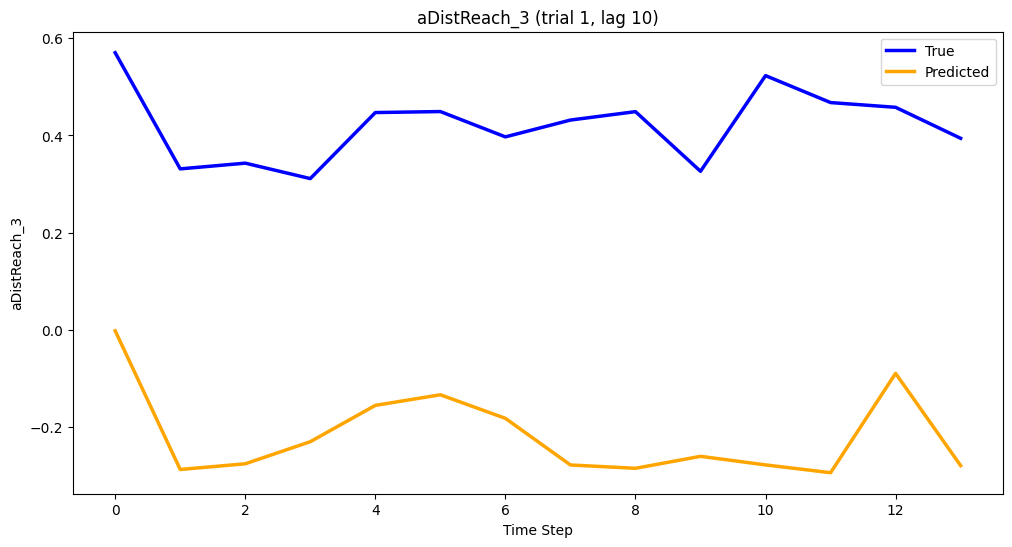

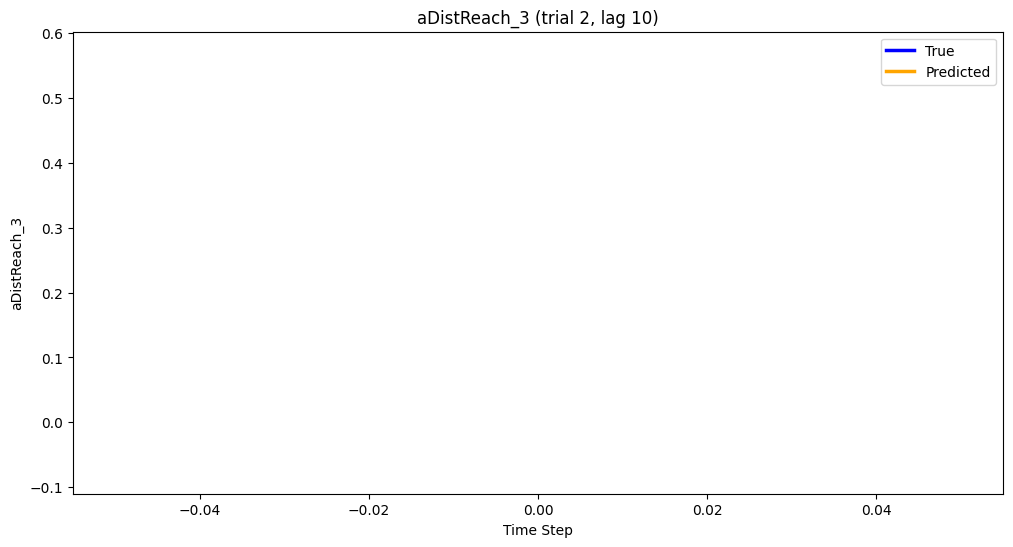

Value 'test_model: 753.6420288085938' saved to 'C:/Users/kacpe/Desktop/lab_rotation_git/test1_variable\results_val/s_results_train.txt' successfully.
Value 'test_model: 1051.0750732421875' saved to 'C:/Users/kacpe/Desktop/lab_rotation_git/test1_variable\results_train/s_results_train.txt' successfully.


In [160]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Hyperparameters
test_set = 1
val_set = 5
# Create the dataset and dataloader
shift = 10
labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'aAngHGFeed1', 'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4','aAngHG_oHead', 'aAngHG_oMid','aAngHG_oReach']
columns_to_shift = ['oAngHGFeed1', 'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4',
       'oDistReach1', 'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1',
       's_2', 's_3', 's_4', 'b_1', 'b_2', 'b_3', 'b_4']

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shifted_df = shift_dataframe(df,shift,columns_to_shift)
print(shifted_df.columns)





train_dataloader, val_dataloader = create_dataloaders(shifted_df,val_set_trial=val_set,features_columns=columns_to_shift,label_columns=labels)

# Directory where you want to save metrics
metrics_dir = os.path.join(current_dir, "metrics")
if not os.path.exists(metrics_dir):
    os.makedirs(metrics_dir)

# Initialize dictionaries to store metrics for each epoch (1 row per epoch)
metrics = {
    'MSE_train': [],
    'MAE_train': [],
    'R2_train': [],
    'MSE_val': [],
    'MAE_val': [],
    'R2_val': []
}
# Hyperparameters
input_dim = 16
hidden_dim = 4
output_dim = 11
num_layers = 1
n_epochs = 1
lr = 0.001

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of GRUCellNet and move it to the device
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers).to(device)

loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=50, verbose=True, threshold=0.01, threshold_mode='rel')

# Prepare for evaluation
eval_functions = {
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R2': r2_score
}

current_dir = "C:/Users/kacpe/Desktop/lab_rotation_git/test1_variable"
if not os.path.exists(current_dir):
    os.makedirs(current_dir)

model_probabilities = {}
model_probabilities_train = {}
mse_train = {}
mae_train = {}
r2_train = {}
mse_val = {}
mae_val = {}
r2_val = {}
model_name = 'test_model'

plot_train_name = model_name + '_train_.png'
plot_test_name = model_name + "_test_.png"
plot_val_name = model_name + "_val_.png"


labels = ['aDistReach_3']
for epoch in range(n_epochs):
    mse_train[model_name] = []
    mae_train[model_name] = []
    r2_train[model_name] = []
    mse_val[model_name] = []
    mae_val[model_name] = []
    r2_val[model_name] = []
    model.train()  # Set model to training mode
    total_loss = 0.0
    y_train_true = []
    y_train_pred = []
    
    for X_batch, y_batch, lengths in train_dataloader:
        # Move data to GPU if available
        X_batch, y_batch, lengths = X_batch.to(model.fc.weight.device), y_batch.to(model.fc.weight.device), lengths.to(model.fc.weight.device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch, lengths)
        
        # Compute loss
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        print(f"y_batch shape: {y_batch.shape}, y_pred shape: {y_pred.shape}")
        
        y_train_true.append(y_batch.detach().cpu().numpy())  # Append the true values
        y_train_pred.append(y_pred.detach().cpu().numpy())  # Append the predicted values

                # Calculate metrics for training
    y_train_true = np.concatenate(y_train_true, axis=0)
    y_train_pred = np.concatenate(y_train_pred, axis=0)
    avg_mae = mean_absolute_error(y_train_true, y_train_pred)
    avg_r2 = r2_score(y_train_true, y_train_pred)
    avg_loss = total_loss / len(train_dataloader)
    #avg_mse = nn.MSELoss(y_train_true,y_train_pred)

    mse_train[model_name].append(avg_loss)
    mae_train[model_name].append(avg_mae)
    r2_train[model_name].append(avg_r2)

    
    # Validation phase after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    y_val_true = []
    y_val_pred = []

    with torch.no_grad():
        for X_val_batch, y_val_batch, lengths in val_dataloader:
            X_val_batch, y_val_batch, lengths = X_val_batch.to(model.fc.weight.device), y_val_batch.to(model.fc.weight.device), lengths.to(model.fc.weight.device)
            
            # Forward pass
            y_pred = model(X_val_batch, lengths)
            
            # Compute loss
            loss = criterion(y_pred, y_val_batch)
            val_loss += loss.item()
    y_val_true.append(y_val_batch.detach().cpu().numpy())
    y_val_pred.append(y_pred.detach().cpu().numpy())
    # Calculate validation metrics
    y_val_true = np.concatenate(y_val_true, axis=0)
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_mae = mean_absolute_error(y_val_true, y_val_pred)
    avg_val_r2 = r2_score(y_val_true, y_val_pred)

    mse_val[model_name].append(avg_val_loss)
    mae_val[model_name].append(avg_val_mae)
    r2_val[model_name].append(avg_val_r2)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Training Loss: {avg_loss}, Validation Loss: {avg_val_loss}')
    
    line_train_dir = "line_plots_train/"
    line_val_dir = "line_plots_val/"

    line_plots_train_path = os.path.join(current_dir, line_train_dir)
    line_plots_val_path = os.path.join(current_dir, line_val_dir)

    if not os.path.exists(line_plots_train_path):
        os.makedirs(line_plots_train_path)

    if not os.path.exists(line_plots_val_path):
        os.makedirs(line_plots_val_path)
    
    train_plot_path = os.path.join(line_plots_train_path, plot_train_name)
    val_plot_path = os.path.join(line_plots_val_path, plot_val_name)

# Save the results and metrics
create_lineplots(y_train_pred, y_train_true, labels, trial=test_set, shift=shift, file_path=train_plot_path, size=(12,6), show_plot=True)
create_lineplots(y_val_pred, y_val_true, labels, trial=val_set, shift=shift, file_path=val_plot_path, size=(12, 6), show_plot=True)

# Saving metrics
save_metrics_to_csv('MSE_train', model_name, mse_train[model_name], current_dir)
save_metrics_to_csv('MAE_train', model_name, mae_train[model_name], current_dir)
save_metrics_to_csv('R2_train', model_name, r2_train[model_name], current_dir)

save_metrics_to_csv('MSE_val', model_name, mse_val[model_name], current_dir)
save_metrics_to_csv('MAE_val', model_name, mae_val[model_name], current_dir)
save_metrics_to_csv('R2_val', model_name, r2_val[model_name], current_dir)

# Define the directory where you want to save the file relative to current_dir
results_train_dir = "results_train/"
results_val_dir = "results_val/"

# Create the full directory path by joining current_dir and relative_dir
results_train_dir_path = os.path.join(current_dir, results_train_dir)
results_val_dir_path = os.path.join(current_dir, results_val_dir)

# Ensure that the directory exists, if not, create it
if not os.path.exists(results_train_dir_path):
    os.makedirs(results_train_dir_path)
if not os.path.exists(results_val_dir_path):
    os.makedirs(results_val_dir_path)

plot_train_name = model_name + '_train_.png'
# Save training results into txt file
save_results(results_val_dir_path, model_name, avg_val_loss)
save_results(results_train_dir_path, model_name, avg_loss)



In [137]:

df = pd.read_csv('data_model_v1.csv')
df = df.drop(columns='id')
shift = 10
val_set = 6

columns_to_shift = ['aDistReach_3']
input_dim = len(columns_to_shift)  # Number of features
hidden_dim = 32
output_dim = len(labels)  # Number of labels
num_layers = 1
learning_rate = 0.001
num_epochs = 10

# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

selected_columns = ['trial', 'aDistReach_3', 'aDistReach_3_minus_' + str(shift)]
features = ['aDistReach_3_minus_10']
labels = ['aDistReach_3']
print(shifted_df.columns)
shifted_df = shifted_df[selected_columns]
print(shifted_df.columns)
train_dataloader, val_dataloader = create_dataloaders(shifted_df,val_set_trial=val_set,features_columns=features,label_columns=labels)

Index(['trial', 'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aAngHGFeed1',
       'aAngHGFeed2', 'aAngHGFeed3', 'aAngHGFeed4', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oAngHGFeed1',
       'oAngHGFeed2', 'oAngHGFeed3', 'oAngHGFeed4', 'oDistReach1',
       'oDistReach2', 'oDistReach3', 'oDistReach4', 's_1', 's_2', 's_3', 's_4',
       'b_1', 'b_2', 'b_3', 'b_4', 'aDistReach_3_minus_10'],
      dtype='object')
Index(['trial', 'aDistReach_3', 'aDistReach_3_minus_10'], dtype='object')


In [117]:
# Function to save metrics
def save_metrics_to_csv(metric_name, model_name, metric_values, current_dir):
    """
    Save a given metric (MSE, MAE, R2) to a CSV file, one row per epoch, one column per model.
    If the file already exists, append the new column for the current model.
    """
    # Define the full path for the metric file
    file_path = os.path.join(current_dir, f"{metric_name}.csv")
    
    # Check if the file already exists
    if os.path.exists(file_path):
        # Load existing data
        df_metrics = pd.read_csv(file_path)
    else:
        # Create a new DataFrame for the first model
        df_metrics = pd.DataFrame()

    # Add the new model's metrics as a column
    df_metrics[model_name] = metric_values
    
    # Save back to CSV
    df_metrics.to_csv(file_path, index=False)

# Directory where you want to save metrics
metrics_dir = os.path.join(current_dir, "metrics")
if not os.path.exists(metrics_dir):
    os.makedirs(metrics_dir)

# Initialize dictionaries to store metrics for each epoch (1 row per epoch)
metrics = {
    'MSE_train': [],
    'MAE_train': [],
    'R2_train': [],
    'MSE_val': [],
    'MAE_val': [],
    'R2_val': []
}

In [118]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, file_path='lineplots.png', size=(10,16), show_plot=False):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size,linewidth=0.01)
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        ax.set_title(f'{label} (trial {trial}, lag {shift})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel(label)

        # Add legend
        ax.legend()

        # Adjust spacing between subplots
        #plt.tight_layout()

    # Save the plots to a file
    plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.show()




In [130]:
def save_results(full_dir_path, model_name, accs_train):
    # Define the file name
    file_name = 's_results_train.txt'

    # Create the full file path by joining the directory path and the file name
    file_path = os.path.join(full_dir_path, file_name)

    # Define the value you want to save
    value_to_save = model_name + ": " + str(accs_train)

    try:
        # Open the file in append mode (create if it doesn't exist)
        with open(file_path, "a+") as file:
            # Move the file cursor to the beginning to check if the file is empty
            file.seek(0)
            # Read the first character of the file
            first_char = file.read(1)
            # If the first character is empty (file is empty), write a new line
            if not first_char:
                file.write('\n')
            # Write the value to the file
            file.write(value_to_save + '\n')
            print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
